In [6]:
# coding=utf-8

import os
from copy import copy
from datetime import datetime, timedelta

import talib
import pandas as pd
import numpy as np

import alphalens as al

from tumbler.service.mysql_service import MysqlService
from tumbler.record.client_quick_query import get_future_symbols
from tumbler.function import datetime_from_str_to_datetime
from tumbler.function.technique import Technique


sys_path_dir = ".tumbler"
day_binance_file = os.path.join(sys_path_dir, "binance_day.csv")

mysql_service_manager = MysqlService()


def day_factor_func(df):
    # val_arr = talib.ADX(df["high"], df["low"], df["close"], timeperiod=14) * \
    #           talib.ADXR(df["high"], df["low"], df["close"], timeperiod=14)
    val_arr = talib.ROC(df["close"], timeperiod=30)
    val_arr[np.isnan(val_arr)] = 0
    # val_arr = Technique.boll(df["close"], 20, dev=1)
    return val_arr


def get_use_symbols(suffix, all_data=True):
    day_symbols = mysql_service_manager.get_mysql_distinct_symbol(table='kline_1day')
    day_symbols = [x for x in day_symbols if
                   x.endswith(suffix) and not x.endswith("down_usdt")
                   and not x.endswith("up_usdt") and not x.endswith("bear_usdt")]
    if not all_data:
        day_symbols = [x for x in day_symbols if x in get_future_symbols(reload=False)]
    else:
        day_symbols = day_symbols
    return day_symbols


def get_df():
    df = pd.read_csv(day_binance_file)
    date_list = list(df["date"])
    date_list = [datetime_from_str_to_datetime(x) for x in date_list]
    df["date"] = date_list
    return df


def make_alphalen_price_df(df, use_symbols, suffix="_usdt"):
    save_filepath = f".tumbler/price{suffix}.csv"
    if os.path.exists(save_filepath):
        df = pd.read_csv(save_filepath, index_col=0)
        df.index = [datetime_from_str_to_datetime(x) for x in list(df.index)]
        return df
    date_list = list(set(list(df["date"])))
    date_list.sort()

    price_df = pd.DataFrame(np.random.rand(len(date_list), 1), index=date_list, columns=["test"])
    for symbol in use_symbols:
        tdf = copy(df[df.symbol == symbol])
        price_df[symbol] = np.nan
        for dt_str, close_price in zip(list(tdf["date"]), list(tdf["close"])):
            price_df.loc[dt_str, symbol] = close_price
    price_df = price_df.drop(columns=["test"])
    price_df.to_csv(save_filepath)
    return price_df


def factor_zscore(df):
    dates = list(set([x[0] for x in list(df.index)]))
    dates.sort()
    
    for d in dates:
        val = np.array(df.loc[d])
        df.loc[d] = (val - np.mean(val)) / np.std(val)
    return df


def make_alphalen_factor_df(df, use_symbols, suffix="_usdt"):
    index_array = []
    factor_array = []
    for symbol in use_symbols:
        if symbol.endswith(suffix):
            tdf = copy(df[df.symbol == symbol])
            if len(tdf.index) == 0:
                continue

            val_arr = day_factor_func(tdf)
            for date, factor_val in zip(tdf.date, val_arr):
                index_array.append((date, symbol))
                factor_array.append(factor_val)

    index = pd.MultiIndex.from_tuples(index_array, names=['date', 'symbol'])
    df = pd.DataFrame(factor_array, index=index)
    df = df.sort_index()
    df.to_csv(".tumbler/factor.csv")
    df = factor_zscore(df)
    df.to_csv(".tumbler/factor_zscore.csv")
    return df


suffix="_usdt"
all_data=True
start_time=datetime(2017, 1, 1)
end_time=datetime.now() + timedelta(hours=3)
day_symbols = get_use_symbols(suffix, all_data)
print(day_symbols)
df = get_df()
print(df)
price_df = make_alphalen_price_df(df, day_symbols, suffix)
price_df.tail(10)

factor_df = make_alphalen_factor_df(df, day_symbols, suffix)
factor_df.tail(10)

factor_data = al.utils.get_clean_factor_and_forward_returns(factor_df, price_df, max_loss=0.99)
print(df)
factor_data.to_csv(".tumbler/alphalens.csv")




['1inch_usdt', 'aave_usdt', 'acm_usdt', 'ada_usdt', 'aion_usdt', 'akro_usdt', 'algo_usdt', 'alice_usdt', 'alpaca_usdt', 'alpha_usdt', 'ankr_usdt', 'ant_usdt', 'ar_usdt', 'ardr_usdt', 'arpa_usdt', 'asr_usdt', 'ata_usdt', 'atm_usdt', 'atom_usdt', 'aud_usdt', 'audio_usdt', 'auto_usdt', 'ava_usdt', 'avax_usdt', 'axs_usdt', 'badger_usdt', 'bake_usdt', 'bal_usdt', 'band_usdt', 'bar_usdt', 'bat_usdt', 'bcc_usdt', 'bch_usdt', 'bchabc_usdt', 'bchsv_usdt', 'beam_usdt', 'bel_usdt', 'bkrw_usdt', 'blz_usdt', 'bnb_usdt', 'bnbbull_usdt', 'bnt_usdt', 'bond_usdt', 'btc_usdt', 'btcst_usdt', 'btg_usdt', 'bts_usdt', 'btt_usdt', 'bull_usdt', 'burger_usdt', 'busd_usdt', 'bzrx_usdt', 'c98_usdt', 'cake_usdt', 'celo_usdt', 'celr_usdt', 'cfx_usdt', 'chr_usdt', 'chz_usdt', 'ckb_usdt', 'clv_usdt', 'cocos_usdt', 'comp_usdt', 'cos_usdt', 'coti_usdt', 'crv_usdt', 'ctk_usdt', 'ctsi_usdt', 'ctxc_usdt', 'cvc_usdt', 'dai_usdt', 'dash_usdt', 'data_usdt', 'dcr_usdt', 'dego_usdt', 'dent_usdt', 'dexe_usdt', 'dgb_usdt', 'dia

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:80: RuntimeWarning: invalid value encountered in true_divide


Dropped 2.7% entries from factor data: 2.1% in forward returns computation and 0.6% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 99.0%, not exceeded: OK!
           symbol exchange       date      open      high       low     close  \
0       1inch_btc  BINANCE 2020-12-25  0.000009  0.000168  0.000009  0.000093   
1       1inch_btc  BINANCE 2020-12-26  0.000093  0.000100  0.000060  0.000060   
2       1inch_btc  BINANCE 2020-12-27  0.000060  0.000062  0.000039  0.000040   
3       1inch_btc  BINANCE 2020-12-28  0.000040  0.000047  0.000040  0.000041   
4       1inch_btc  BINANCE 2020-12-29  0.000041  0.000041  0.000029  0.000032   
...           ...      ...        ...       ...       ...       ...       ...   
346339   zrx_usdt  BINANCE 2021-07-20  0.584300  0.596600  0.523500  0.547600   
346340   zrx_usdt  BINANCE 2021-07-21  0.546700  0.658800  0.530000  0.635800   
346341   zrx_usdt  BINANCE 2021-07-22  0.636500  0.642000  0.610200  0.641

In [26]:
factor_df.head(50)

0
date       asset        
2017-08-17 btc_usdt  NaN
           eth_usdt  NaN
2017-08-18 btc_usdt  NaN
           eth_usdt  NaN
2017-08-19 btc_usdt  NaN
           eth_usdt  NaN
2017-08-20 btc_usdt  NaN
           eth_usdt  NaN
2017-08-21 btc_usdt  NaN
           eth_usdt  NaN
2017-08-22 btc_usdt  NaN
           eth_usdt  NaN
2017-08-23 btc_usdt  NaN
           eth_usdt  NaN
2017-08-24 btc_usdt  NaN
           eth_usdt  NaN
2017-08-25 btc_usdt  NaN
           eth_usdt  NaN
2017-08-26 btc_usdt  NaN
           eth_usdt  NaN
2017-08-27 btc_usdt  NaN
           eth_usdt  NaN
2017-08-28 btc_usdt  NaN
           eth_usdt  NaN
2017-08-29 btc_usdt  NaN
           eth_usdt  NaN
2017-08-30 btc_usdt  NaN
           eth_usdt  NaN
2017-08-31 btc_usdt  NaN
           eth_usdt  NaN
2017-09-01 btc_usdt  1.0
           eth_usdt -1.0
2017-09-02 btc_usdt -1.0
           eth_usdt  1.0
2017-09-03 btc_usdt -1.0
           eth_usdt  1.0
2017-09-04 btc_usdt  1.0
           eth_usdt -1.0
2017-09-05 btc_usdt -1.0
           eth_usdt  1.0
2017-09-06 btc_usdt -1.0
           eth_usdt  1.0
2017-09-07 btc_usdt  1.0
           eth_usdt -1.0
2017-09-08 btc_usdt  1.0
           eth_usdt -1.0
2017-09-09 btc_usdt  1.0
           eth_usdt -1.0
2017-09-10 btc_usdt -1.0
           eth_usdt  1.0

In [20]:

factor_data.to_csv(".tumbler/factor_data.csv")

In [3]:
factor_data.head(30)

1D        5D       10D    factor  factor_quantile
date       asset                                                              
2020-12-25 1inch_usdt -0.304391 -0.523656 -0.550536  0.071845              4.0
2020-12-26 1inch_usdt -0.335379 -0.145926 -0.217073 -0.222811              3.0
2020-12-27 1inch_usdt  0.049755  0.088391  0.422917 -0.240064              3.0
2020-12-28 1inch_usdt -0.206014 -0.079892  0.160233 -0.224686              3.0
2020-12-29 1inch_usdt  0.236179  0.252685  0.341662 -0.147906              3.0
2020-12-30 1inch_usdt  0.247211 -0.056429  0.136912 -0.058778              4.0
2020-12-31 1inch_usdt -0.153040 -0.083303 -0.115788 -0.141178              3.0
2021-01-01 1inch_usdt -0.112554  0.307359 -0.026580 -0.072233              4.0
2021-01-02 1inch_usdt  0.080976  0.260976  0.100000 -0.038508              4.0
2021-01-03 1inch_usdt -0.068863  0.071029  0.152527 -0.358023              3.0
2021-01-04 1inch_usdt  0.211689  0.204905  0.298343 -0.265153              3.0
2021-01-05 1inch_usdt  0.207903 -0.035437  0.081194 -0.359712              3.0
2021-01-06 1inch_usdt -0.144040 -0.255430  0.080728 -0.483880              2.0
2021-01-07 1inch_usdt -0.081857 -0.127660  0.575397 -0.613603              2.0
2021-01-08 1inch_usdt  0.047527  0.076093  0.586500 -0.619675              2.0
2021-01-09 1inch_usdt -0.030006  0.077548  0.528839 -0.832730              1.0
2021-01-10 1inch_usdt -0.067590  0.120916  0.531763 -0.875110              1.0
2021-01-11 1inch_usdt  0.002846  0.451481  0.395535 -0.575176              2.0
2021-01-12 1inch_usdt  0.132594  0.805942  0.557605 -0.494181              2.0
2021-01-13 1inch_usdt  0.048943  0.474315  0.512060 -0.628551              2.0
2021-01-14 1inch_usdt  0.009033  0.418813  0.847182 -0.644190              2.0
2021-01-15 1inch_usdt  0.207384  0.366529  0.744969 -0.606675              2.0
2021-01-16 1inch_usdt  0.247748 -0.038544  0.647221 -0.691119              1.0
2021-01-17 1inch_usdt -0.075386 -0.137511  0.225567 -0.724787              1.0
2021-01-18 1inch_usdt  0.009455  0.025602  0.657035 -0.779058              1.0
2021-01-19 1inch_usdt -0.028150  0.301921  0.763273 -0.754300              1.0
2021-01-20 1inch_usdt -0.150514  0.276936  1.482945 -0.811114              1.0
2021-01-21 1inch_usdt  0.119312  0.713257  2.142702 -0.623608              1.0
2021-01-22 1inch_usdt  0.099476  0.420966  1.858103 -0.922637              1.0
2021-01-23 1inch_usdt  0.281423  0.615671  1.419286 -0.074816              1.0

Quantiles Statistics


min        max      mean       std  count    count %
factor_quantile                                                           
1.0             -4.634050  -0.074283 -0.850977  0.462778  23599  20.814811
2.0             -1.262879   0.454597 -0.442319  0.177960  22194  19.575572
3.0             -0.729305   0.805482 -0.173991  0.155286  22411  19.766970
4.0             -0.377278   1.531069  0.205090  0.288691  22887  20.186812
5.0             -0.070785  14.700359  1.306040  1.406577  22285  19.655835

Returns Analysis


1D       5D     10D
Ann. alpha                                      0.165   -0.439   1.154
beta                                           -0.024    1.846   0.205
Mean Period Wise Return Top Quantile (bps)     19.737  103.689  78.103
Mean Period Wise Return Bottom Quantile (bps)  -9.760  -36.087 -58.442
Mean Period Wise Spread (bps)                  29.497   38.033  40.244

<Figure size 432x288 with 0 Axes>

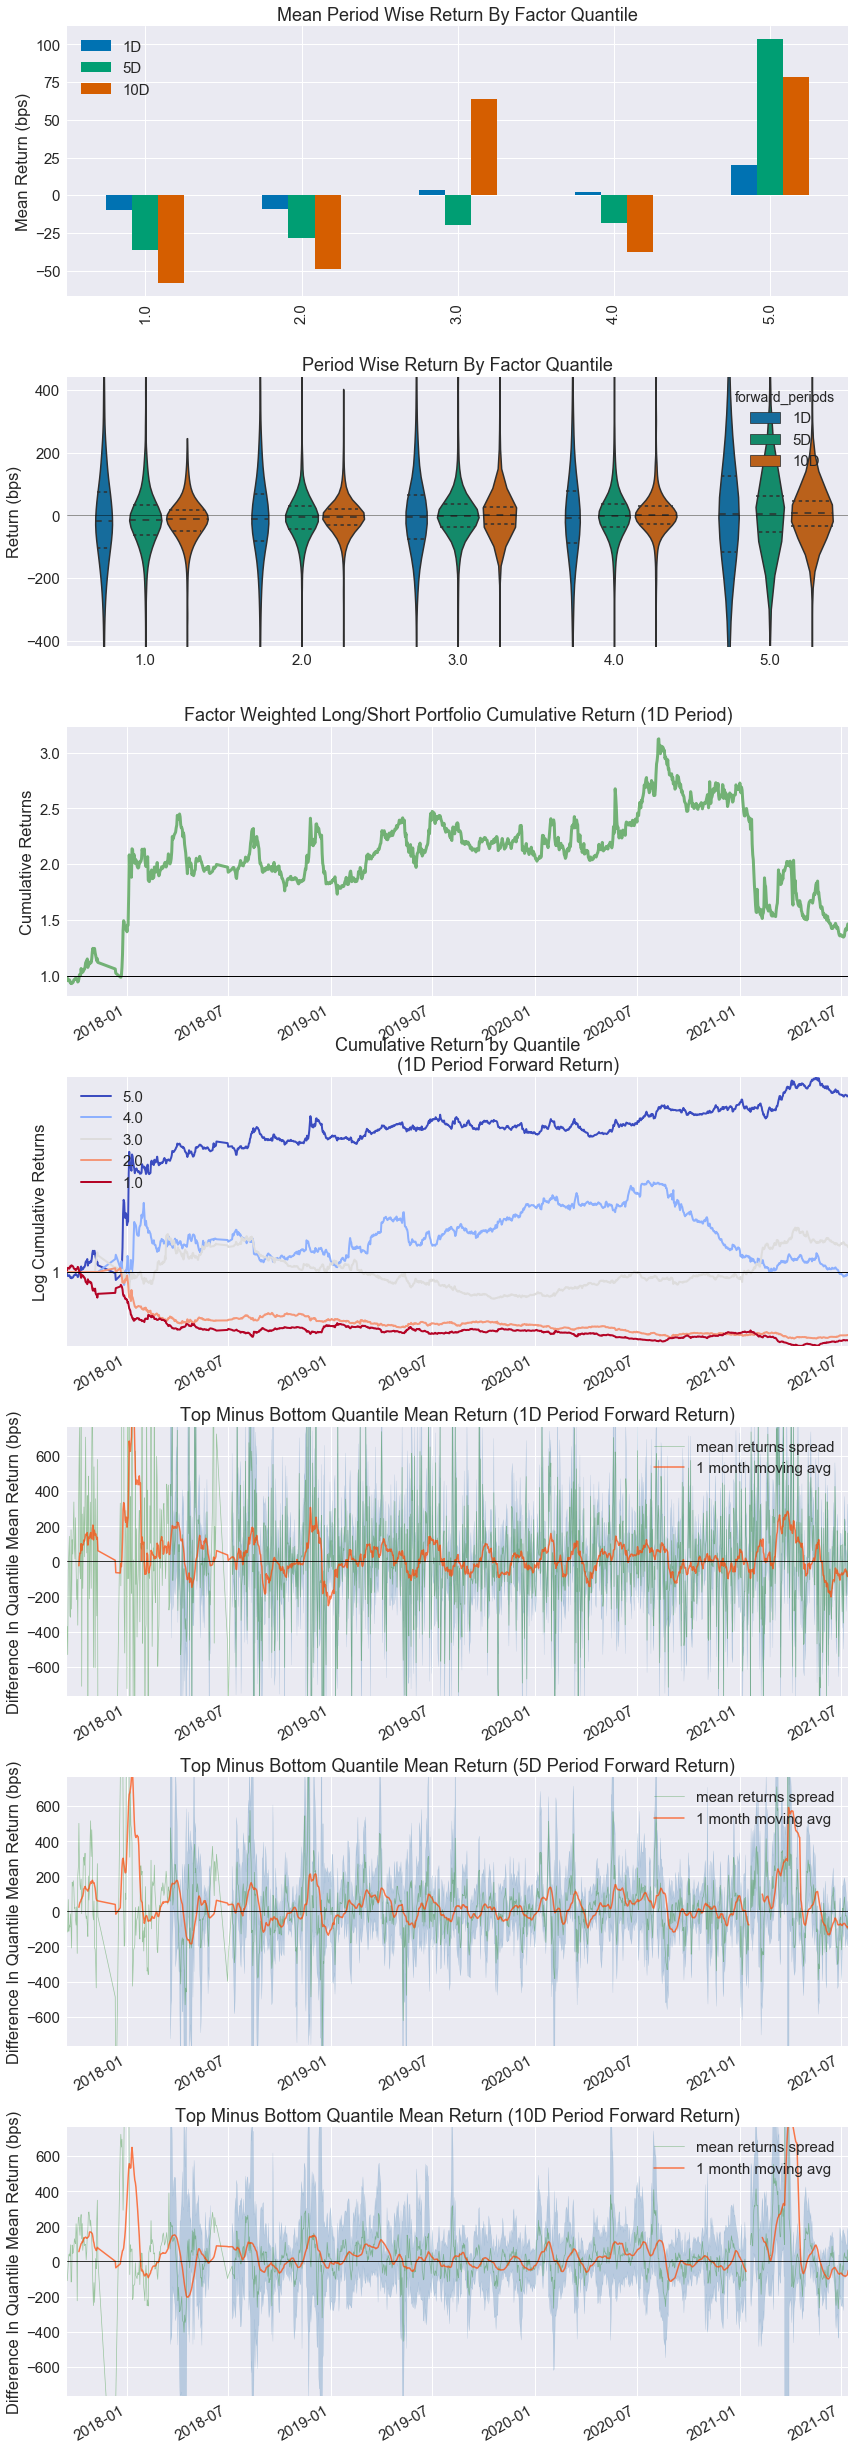

Information Analysis


1D     5D    10D
IC Mean          -0.001  0.018  0.042
IC Std.           0.330  0.343  0.341
Risk-Adjusted IC -0.002  0.051  0.122
t-stat(IC)       -0.066  1.874  4.452
p-value(IC)       0.947  0.061  0.000
IC Skew           0.280  0.139  0.372
IC Kurtosis       1.908  1.369  1.335

/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


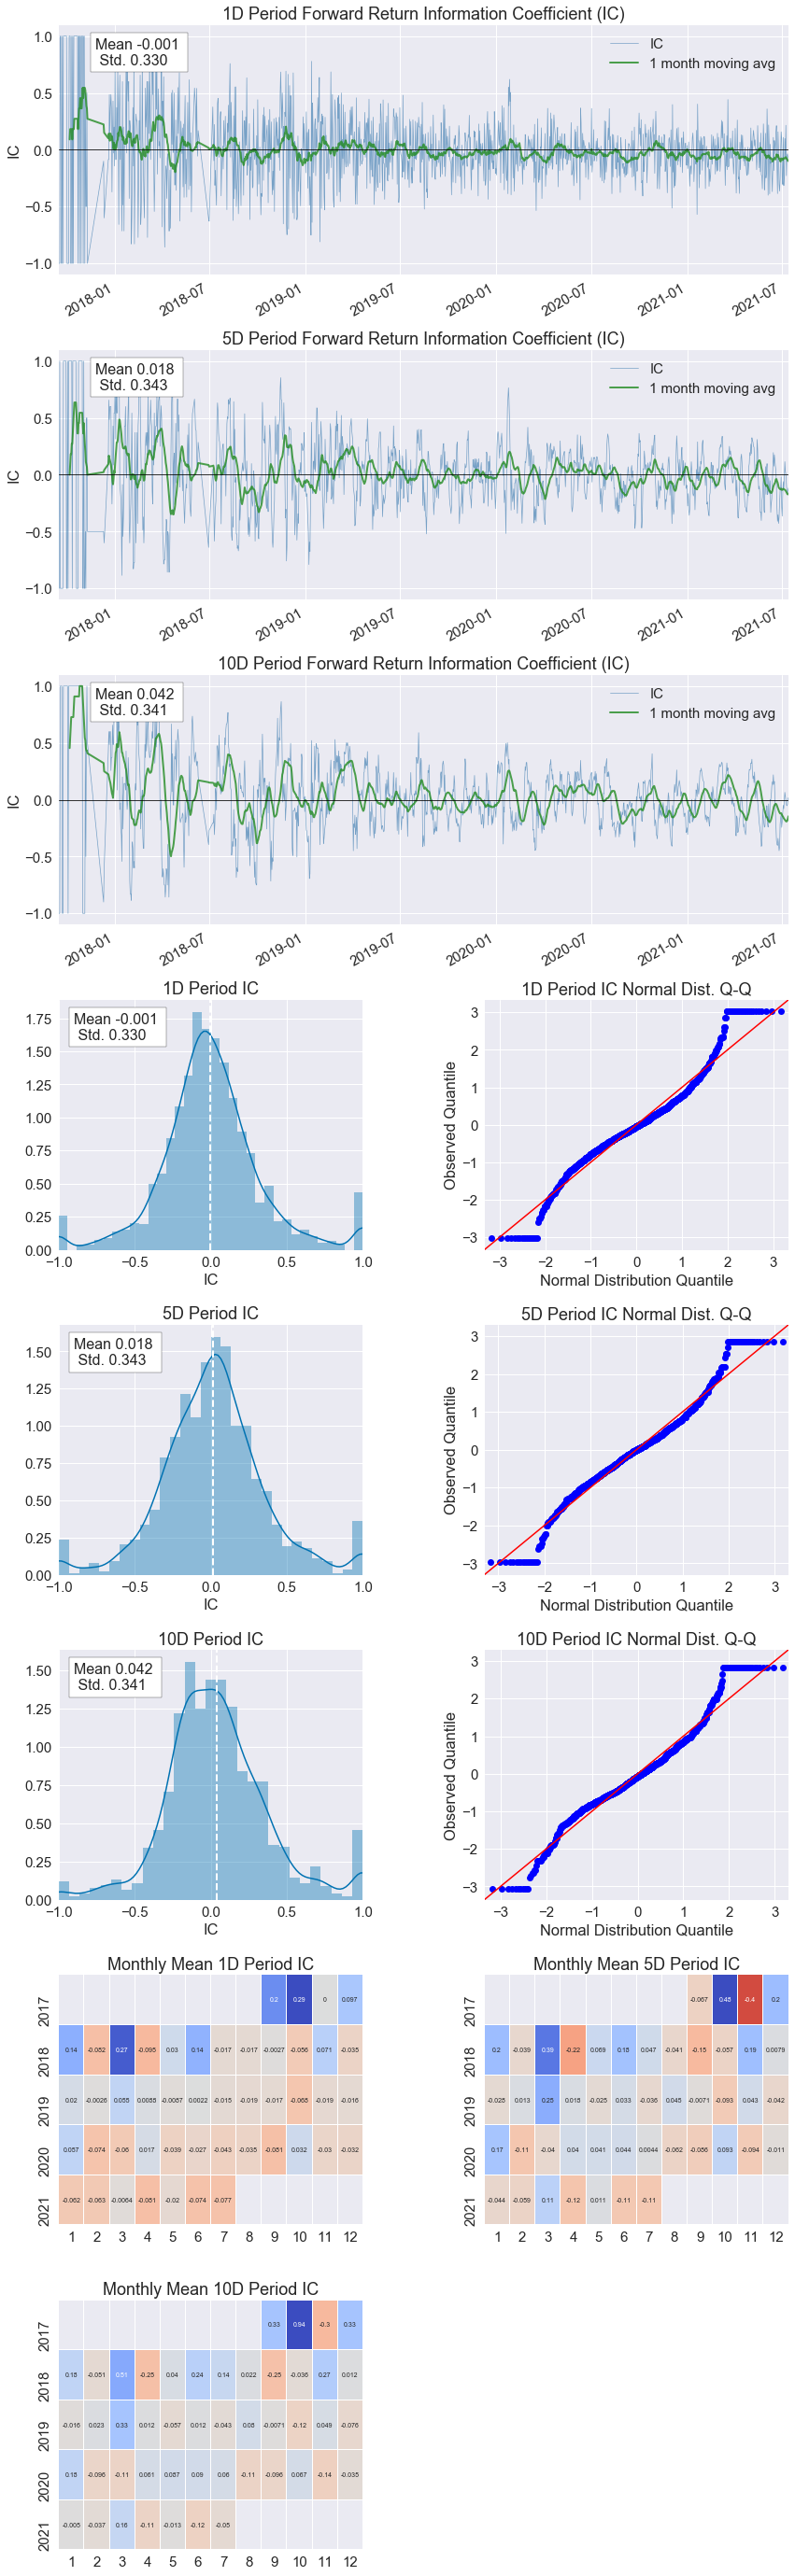

/usr/local/lib/python3.7/site-packages/alphalens-0.4.0-py3.7.egg/alphalens/utils.py:911: UserWarning: Skipping return periods that aren't exact multiples of days.
/usr/local/lib/python3.7/site-packages/alphalens-0.4.0-py3.7.egg/alphalens/tears.py:433: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.


Turnover Analysis


1D     5D    10D
Quantile 1.0 Mean Turnover   0.162  0.337  0.477
Quantile 2.0 Mean Turnover   0.351  0.582  0.697
Quantile 3.0 Mean Turnover   0.366  0.610  0.709
Quantile 4.0 Mean Turnover   0.311  0.545  0.658
Quantile 5.0 Mean Turnover   0.139  0.303  0.437

1D     5D    10D
Mean Factor Rank Autocorrelation  0.93  0.771  0.598

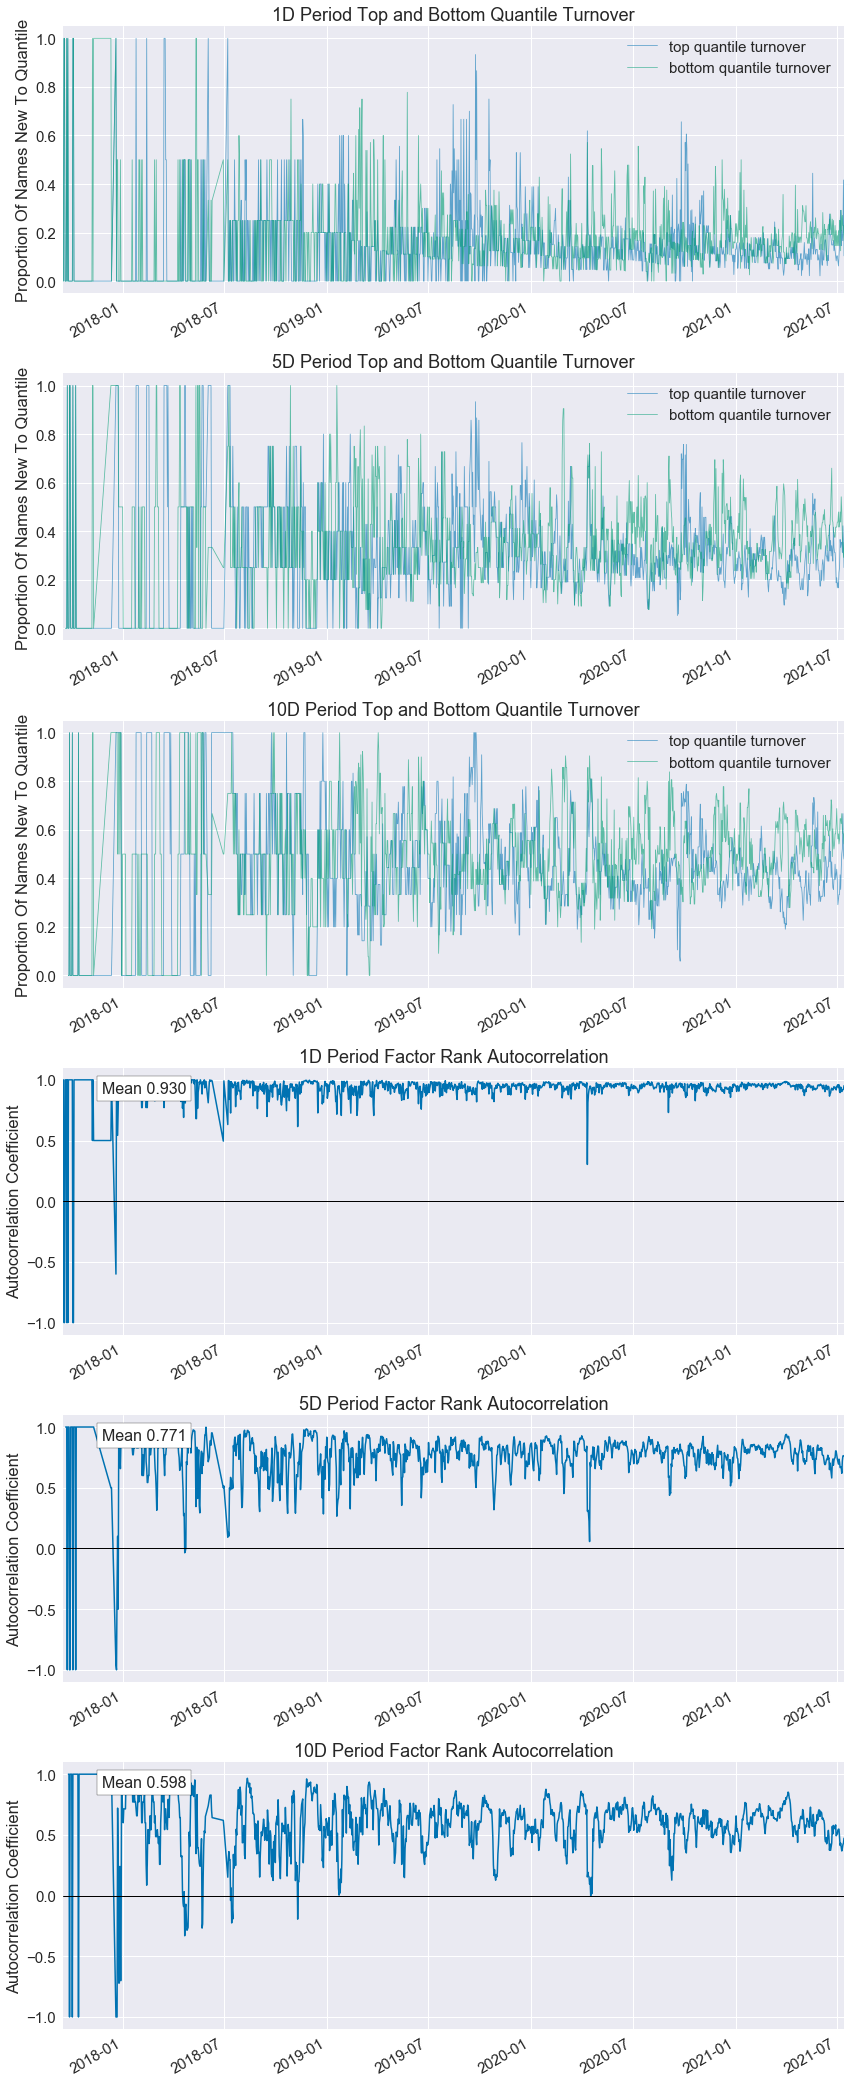

In [7]:
from alphalens.tears import (create_returns_tear_sheet,
                      create_information_tear_sheet,
                      create_turnover_tear_sheet,
                      create_summary_tear_sheet,
                      create_full_tear_sheet,
                      create_event_returns_tear_sheet,
                      create_event_study_tear_sheet)

create_full_tear_sheet(factor_data, long_short=True, group_neutral=False, by_group=False)

Returns Analysis


1D      5D     10D
Ann. alpha                                      0.155   0.503  -0.656
beta                                            0.002  -0.503   0.864
Mean Period Wise Return Top Quantile (bps)      0.587 -11.545  64.108
Mean Period Wise Return Bottom Quantile (bps) -12.674 -25.039 -21.295
Mean Period Wise Spread (bps)                  13.261  10.232   3.259

<Figure size 432x288 with 0 Axes>

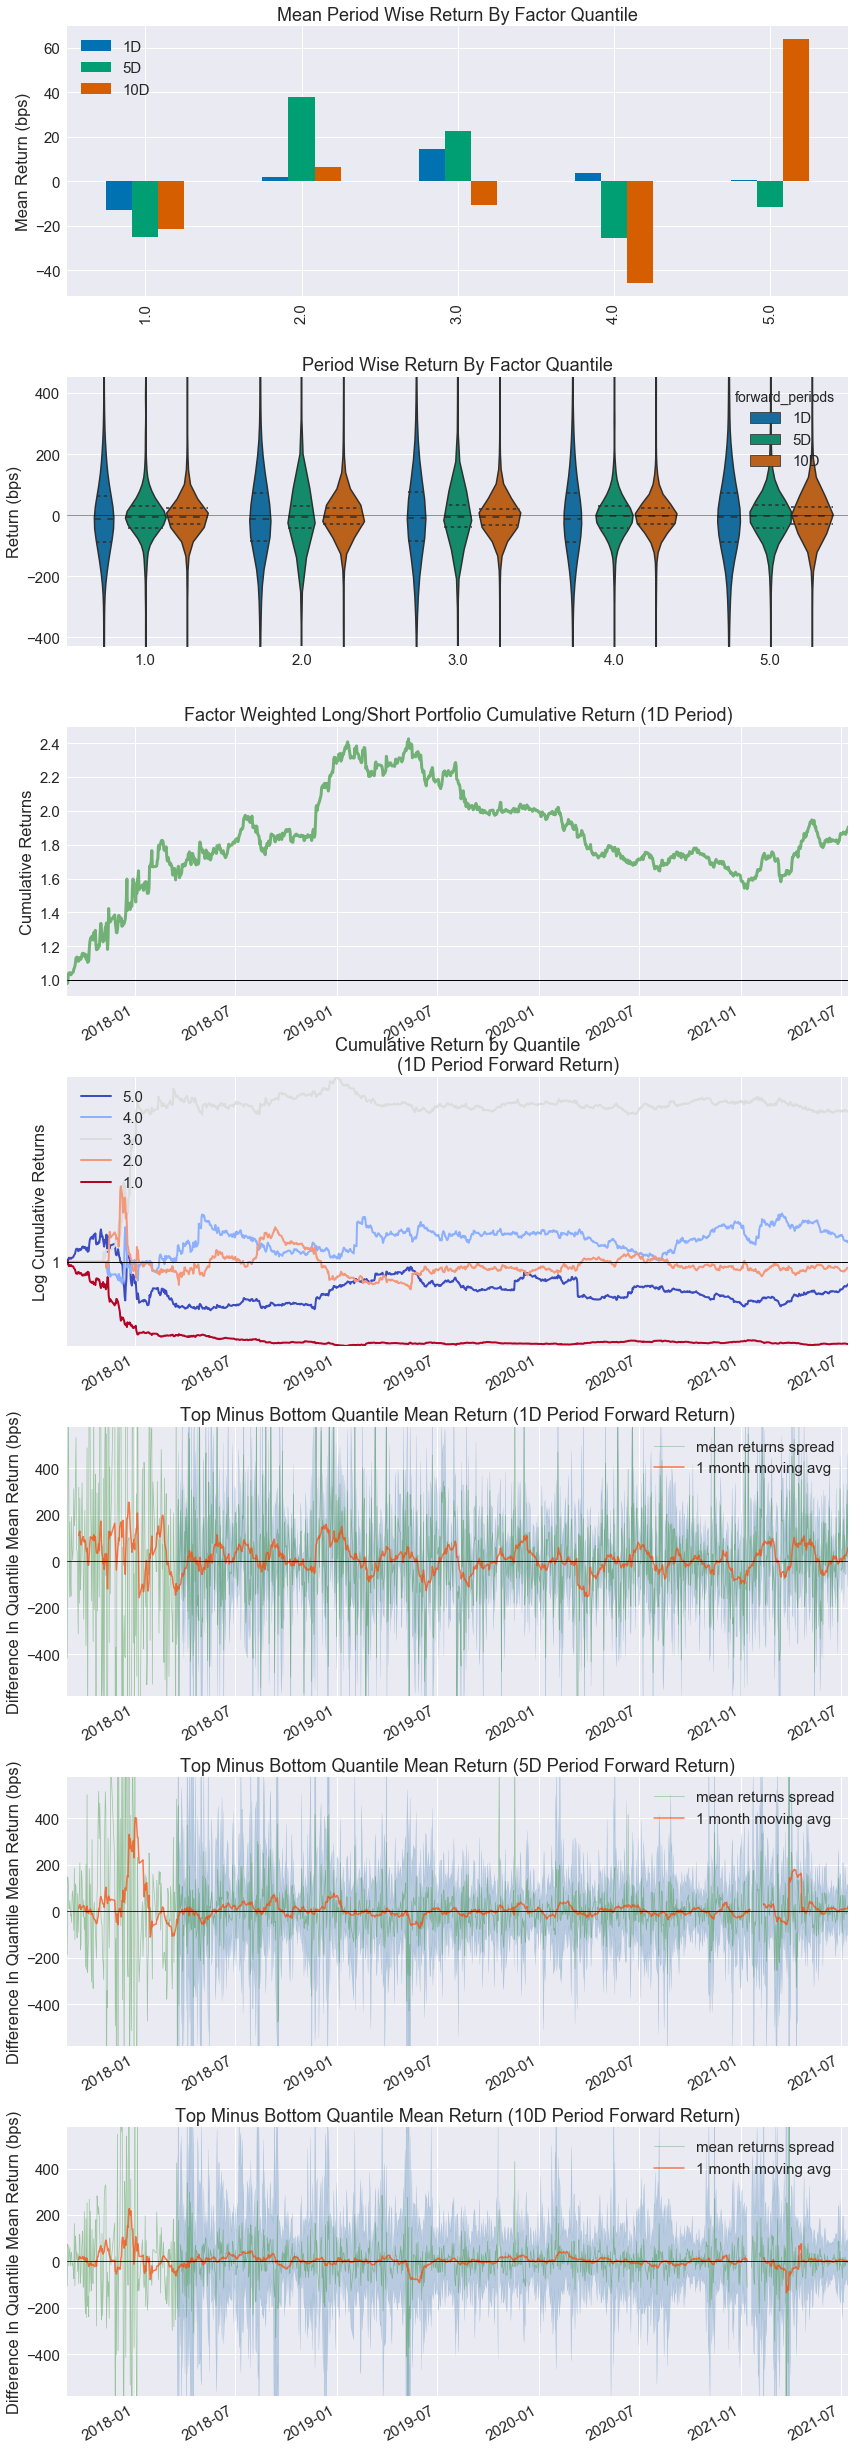

In [12]:
al.tears.create_returns_tear_sheet(factor_data)

Information Analysis


1D     5D    10D
IC Mean           0.021  0.005  0.015
IC Std.           0.314  0.313  0.313
Risk-Adjusted IC  0.065  0.016  0.048
t-stat(IC)        2.363  0.591  1.737
p-value(IC)       0.018  0.555  0.083
IC Skew           0.162  0.046  0.017
IC Kurtosis       3.863  3.941  3.877

/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)
/usr/local/lib/python3.7/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


<Figure size 432x288 with 0 Axes>

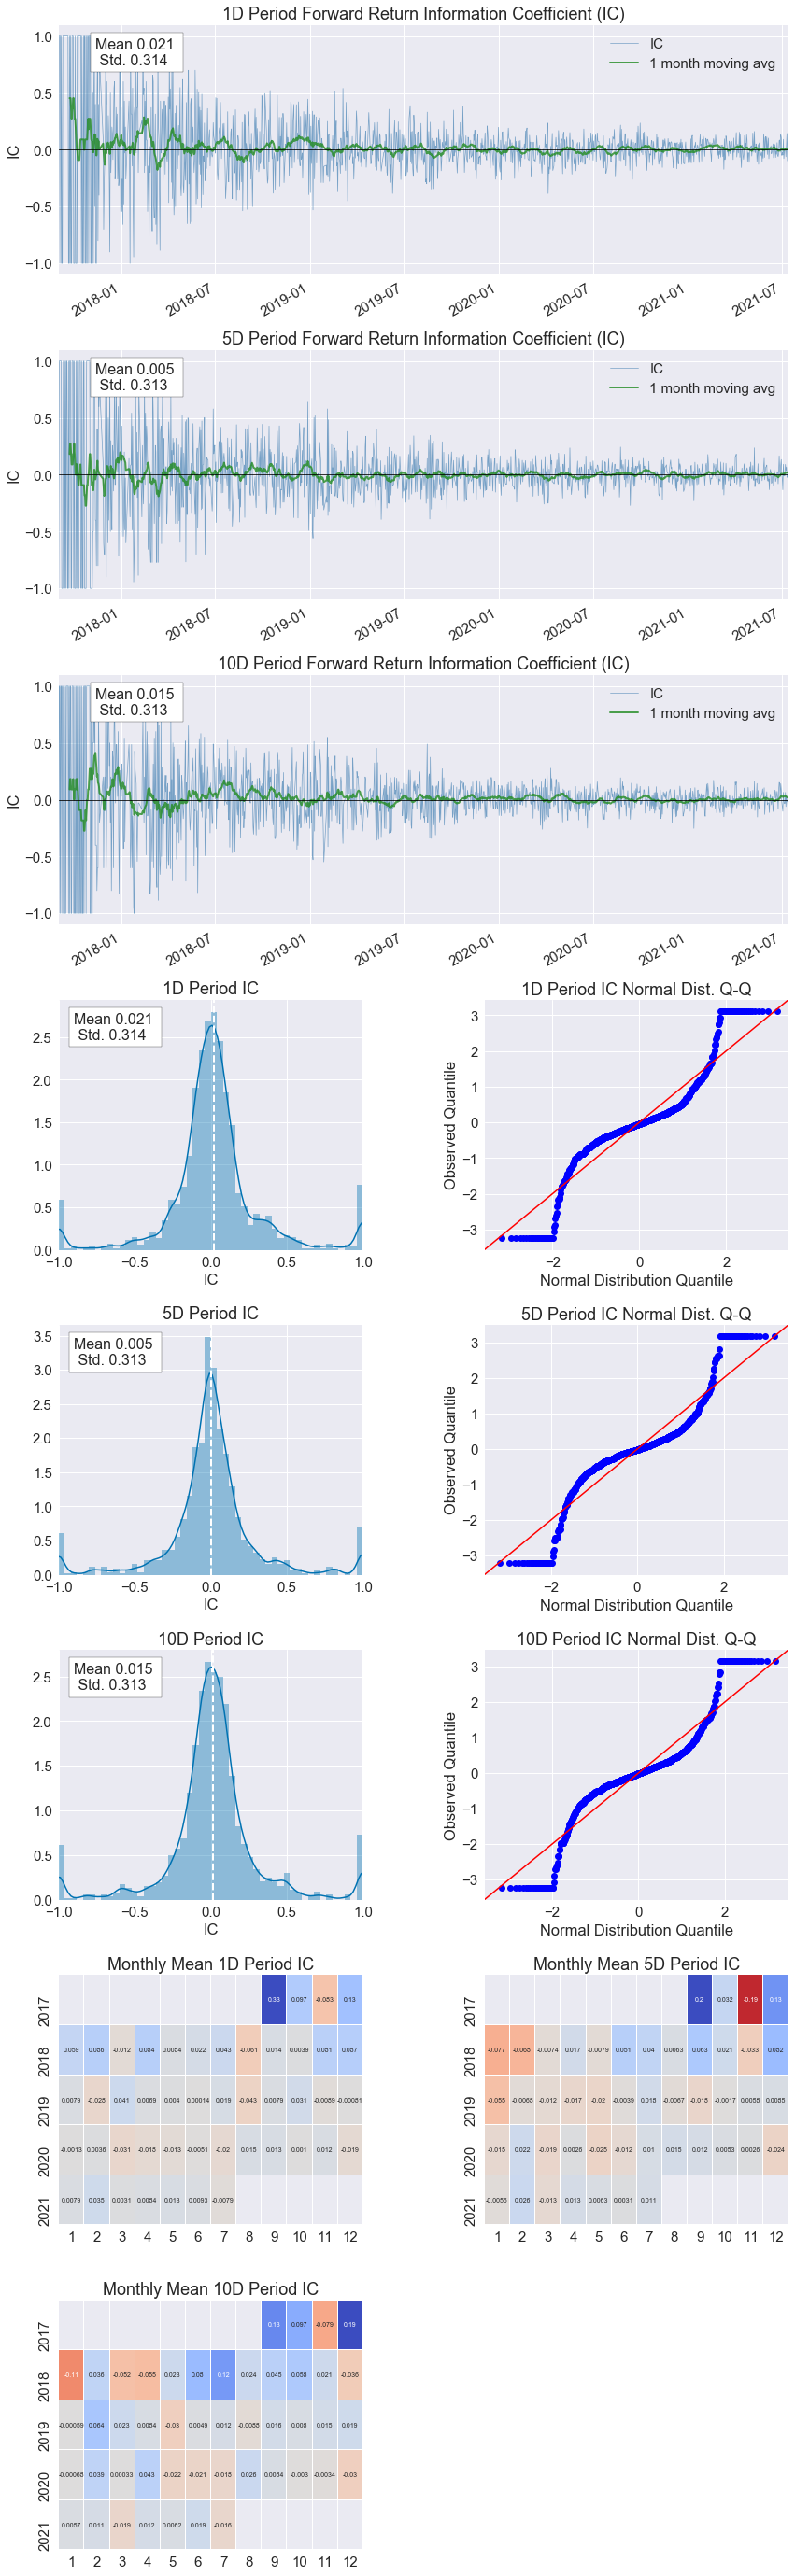

In [15]:
al.tears.create_information_tear_sheet(factor_data)

In [ ]:
pf.create_full_tear_sheet(returns=ret,benchmark_rets=benchmark_ret,live_start_date=date)

<Figure size 432x288 with 0 Axes>

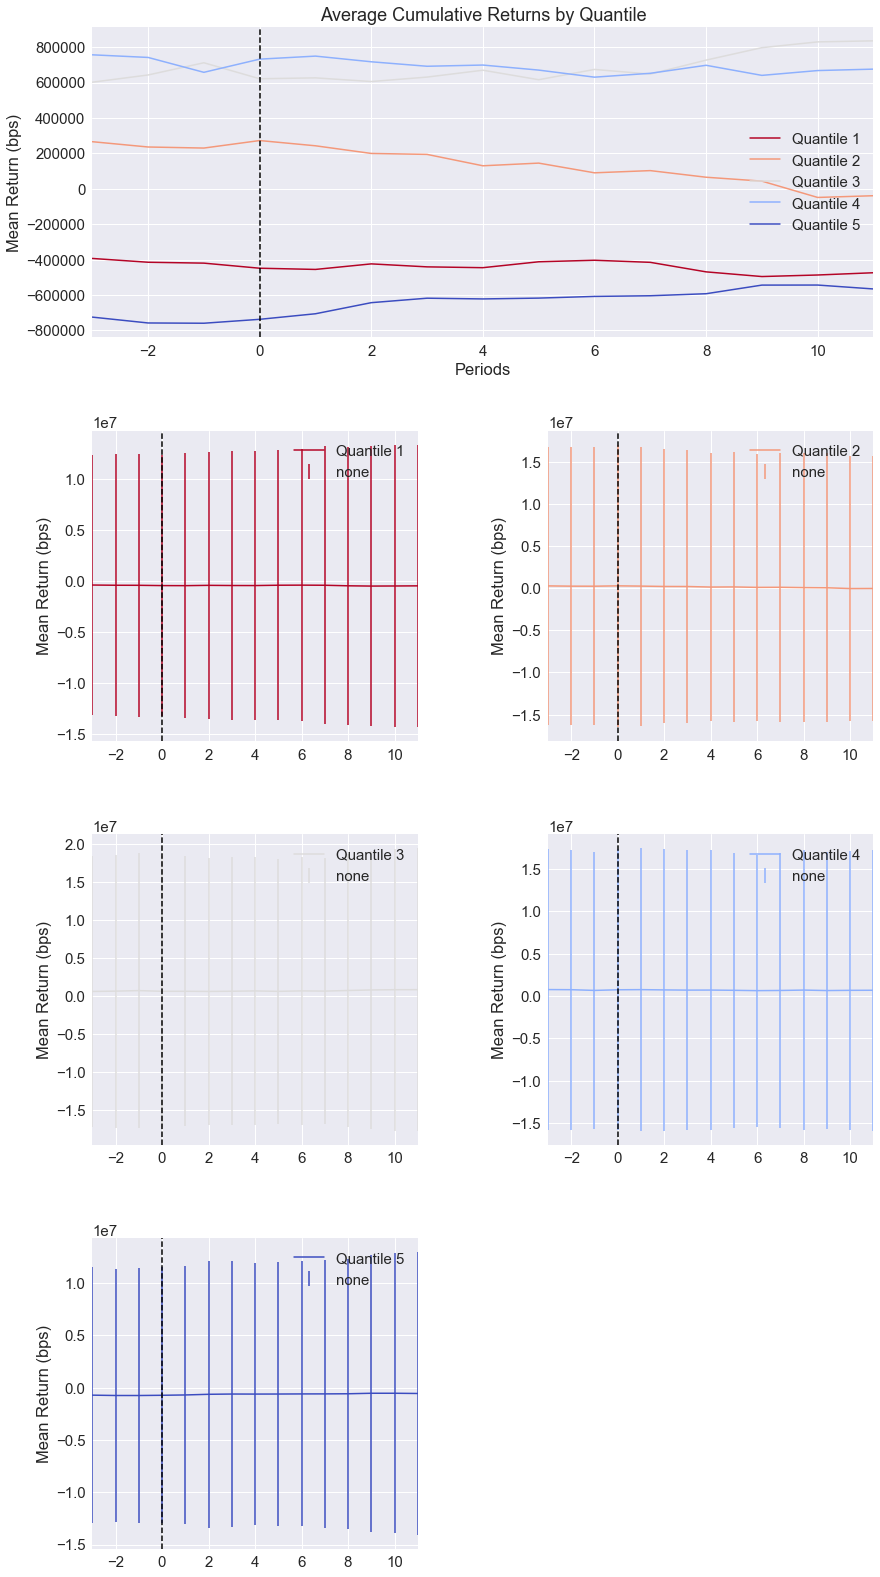

In [4]:
create_event_returns_tear_sheet(factor_data, price_df, avgretplot=(3, 11),
                                long_short=True, group_neutral=False, by_group=False)